In [1]:
import zarr
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from global_land_mask import globe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import scipy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Image

mpl.rcParams['figure.dpi']= 150
plt.rcParams.update({'font.size': 8})
mpl.rcParams['axes.linewidth'] = 0.3
g = 9.80616 #Avg. gravity acceleration on Earth

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 11
Total threads: 11,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65214,Workers: 11
Dashboard: http://127.0.0.1:8787/status,Total threads: 11
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:65286,Total threads: 1
Dashboard: http://127.0.0.1:65371/status,Memory: 1.64 GiB
Nanny: tcp://127.0.0.1:65217,


2025-07-16 17:55:51,114 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1051s; attempting restart: <WorkerState 'tcp://127.0.0.1:65286', name: 0, status: running, memory: 0, processing: 0>
2025-07-16 17:55:51,206 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1051s; attempting restart: <WorkerState 'tcp://127.0.0.1:65287', name: 3, status: running, memory: 0, processing: 0>
2025-07-16 17:55:51,206 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1051s; attempting restart: <WorkerState 'tcp://127.0.0.1:65288', name: 2, status: running, memory: 0, processing: 0>
2025-07-16 17:55:51,207 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1051s; attempting restart: <WorkerState 'tcp://127.0.0.1:65289', name: 8, status: running, memory: 0, processing: 0>
2025-07-16 17:55:51,207 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1051s; attempting restart: <WorkerState 'tcp://127.0.0.1:65290', name: 10, st

In [11]:
# Climatology ERA5 dataset
clim = xr.open_zarr('gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_1440x721.zarr', chunks='auto')

In [19]:
# Gulf
lat1, lat2 = 45, 10
lon1, lon2 = 250, 300



# Texas
lat1, lat2 = 37, 25.5
lon1, lon2 = 253, 270

In [20]:
clim_sel = clim.sel(latitude=slice(lat1,lat2), longitude=slice(lon1,lon2))

In [21]:
l=[]
for i in clim_sel.longitude:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, clim_sel.latitude)
mask1 = globe.is_land(lat_grid, lon_grid)

In [29]:
variables = ['total_column_water_vapour', 'total_precipitation_6hr', 'volumetric_soil_water_layer_1', 'specific_humidity', 'u_component_of_wind', 'v_component_of_wind']
ds_sel = clim_sel[variables].mean(dim='hour')

In [39]:
soilm = ds_sel.volumetric_soil_water_layer_1.where(mask1>0).mean(dim=['latitude', 'longitude'])
mtpr = 24*1000*ds_sel.total_precipitation_6hr.where(mask1>0).mean(dim=['latitude', 'longitude'])/6
tcwv = ds_sel.total_column_water_vapour.where(mask1>0).mean(dim=['latitude', 'longitude'])
tcwv_in = ds_sel.total_column_water_vapour.where(mask1==0).mean(dim=['latitude', 'longitude'])

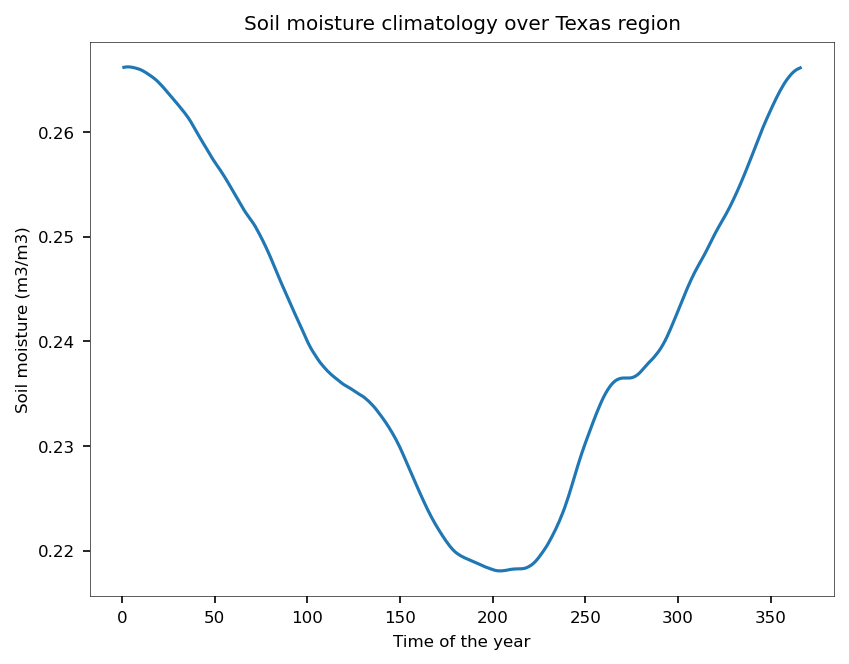

In [26]:
soilm.plot()
plt.xlabel('Time of the year')
plt.ylabel('Soil moisture (m3/m3)')
plt.title('Soil moisture climatology over Texas region')
plt.show()

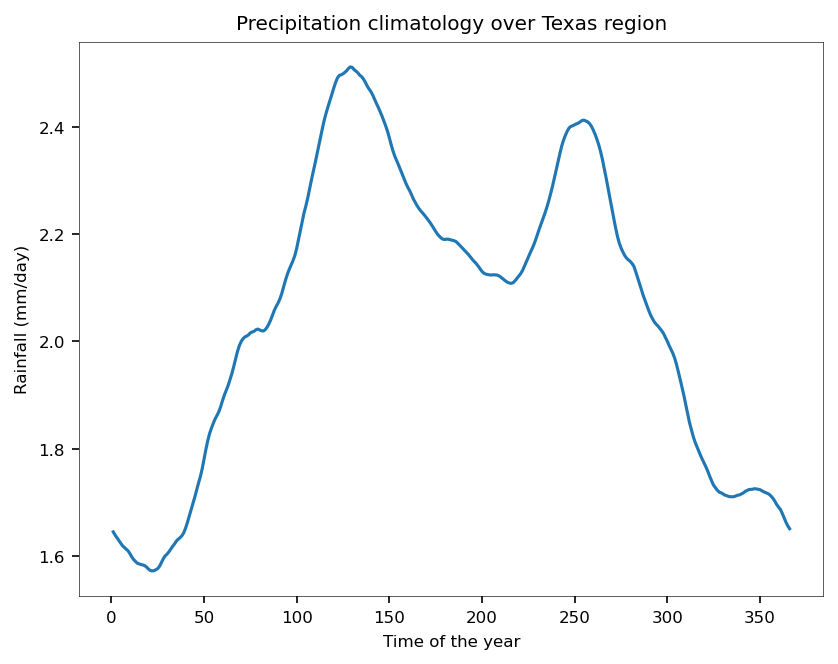

In [35]:
mtpr.plot()
plt.xlabel('Time of the year')
plt.ylabel('Rainfall (mm/day)')
plt.title('Precipitation climatology over Texas region')
plt.show()

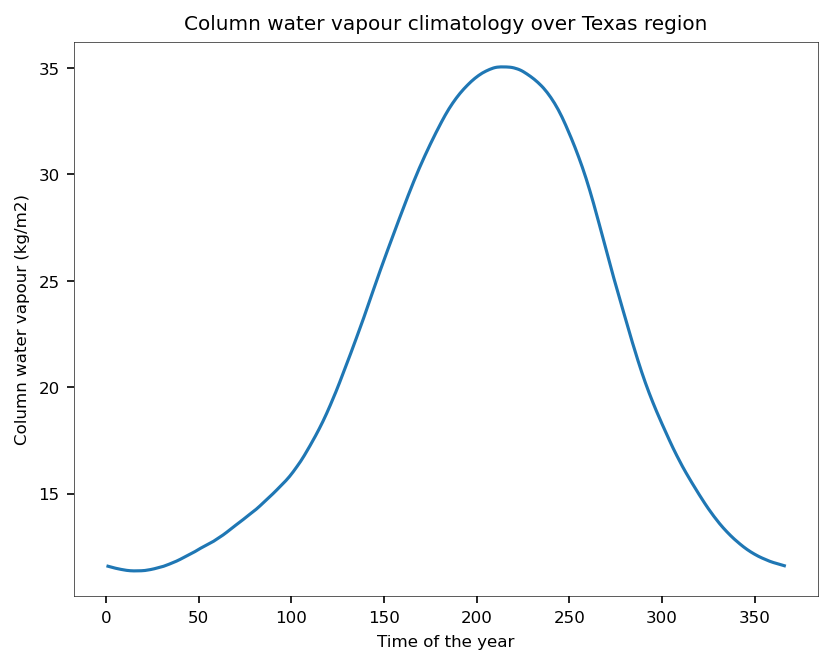

In [38]:
tcwv.plot()
plt.xlabel('Time of the year')
plt.ylabel('Column water vapour (kg/m2)')
plt.title('Column water vapour climatology over Texas region')
plt.show()

In [41]:
qu = ds_sel.specific_humidity*ds_sel.u_component_of_wind
qv = ds_sel.specific_humidity*ds_sel.v_component_of_wind

In [42]:
qu_int = 100*qu.integrate('level')/g #multiply by 100 to convert hPa to Pa (SI)
qv_int = 100*qv.integrate('level')/g

In [43]:
IVT = np.sqrt(qv_int**2 + qu_int**2)

In [45]:
IVT_mean = IVT.where(mask1==0).mean(dim=['latitude', 'longitude'])

KeyboardInterrupt: 

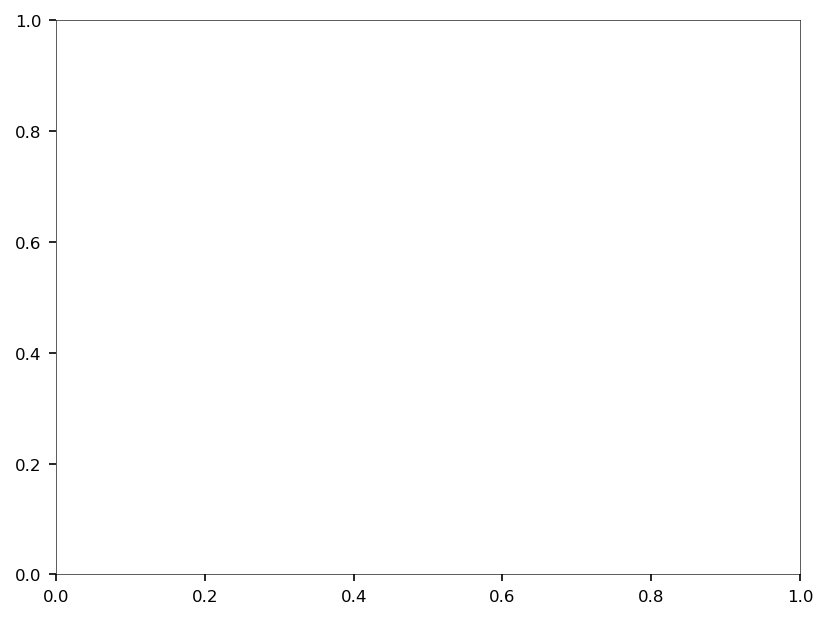

2025-07-16 17:20:50,337 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 4 memory: 61 MB fds: 54>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/era5env/lib/python3.10/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
  File "/opt/miniconda3/envs/era5env/lib/python3.10/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/opt/miniconda3/envs/era5env/lib/python3.10/site-packages/psutil/__init__.py", line 2148, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2025-07-16 17:55:51,267 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_dataset-getitem-269d6670c85ce89b98f6300ba76ed5ab', 1, 68, 8, 0, 0))" coro=<Worker.execute() done, defined at /opt/miniconda3/envs/era5env/lib/python3.10/site-packages/distributed/wo

In [46]:
plt.plot(IVT_mean.dayofyear, IVT_mean)

In [3]:
data = xr.open_dataset('/Users/rm65238/Documents/Work/TROPICS03.PRPS.L2B.Orbit11677.V04-02.ST20250704-134211.ET20250704-151440.CT20250705-040350.nc', decode_times=False)

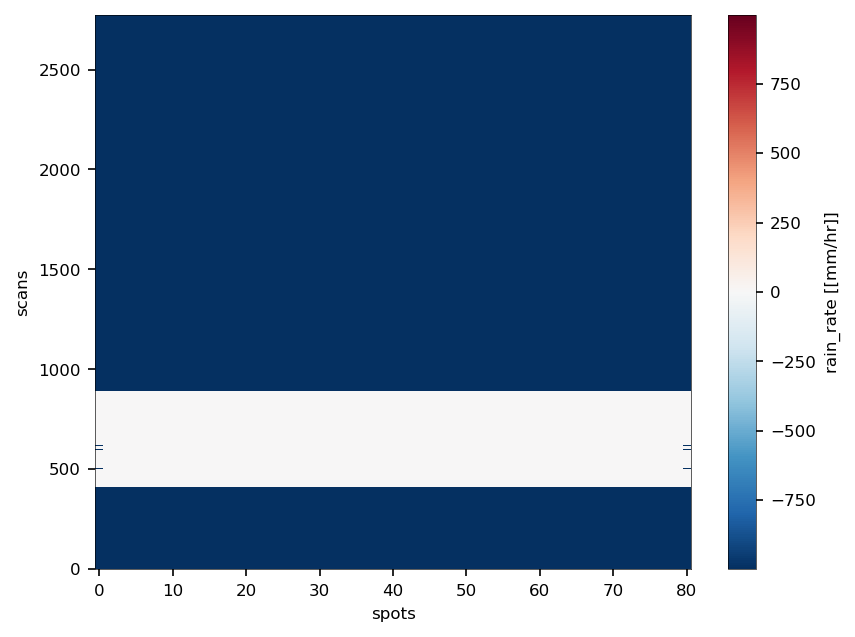

In [7]:
data.rain_rate.plot()

In [ ]:
# Setup plot
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

gls = ax.gridlines(draw_labels=True, color='none')
gls.top_labels = False
gls.right_labels = False

current_plot = [pik_sel.footprints.plot.contour(cmap='black',
    transform=ccrs.PlateCarree(), add_colorbar=False, vmin=200)]